<h4>Mironov Mikhail. Master Thesis. Main research notebook</h4>

In [1]:
import warnings
from datetime import date, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from core.currency import Currency
from core.exchange import Exchange
from core.time_utils import Bounds
from core.utils import configure_logging
from ml_base.features import FeatureFilter, get_importance_file_path
from ml_base.metrics import log_lgbm_iteration_to_stdout
from typing import *

warnings.simplefilter("ignore")

configure_logging()

In [ ]:
# Load features that are the most impactful
feature_filter: FeatureFilter = FeatureFilter.from_importance(
    get_importance_file_path(day=date(2025, 5, 25), target_exchange=Exchange.BINANCE_SPOT),
    use_first=25
)

feature_filter.allowed_features[:10]

<h4>Define bounds for TRAIN and TEST samples</h4>

In [ ]:
train_bounds: Bounds = Bounds.for_days(
    date(2025, 4, 1), date(2025, 5, 5)
)

<h4>Build model manually</h4>


<p>Using BuildDataset read all features and split them into TRAIN and VALIDATION samples</p>

In [ ]:
from core.currency import get_target_currencies
from models.prediction.build_sample import BuildDataset
from ml_base.sample import SampleParams, Sample, MLDataset
from ml_base.enums import DatasetType

sample: Sample = (
    BuildDataset(
        target_exchange=Exchange.OKX_SPOT,
        feature_filter=feature_filter,
        target_currencies=get_target_currencies(),
        forecast_step=timedelta(seconds=5),
    )
    .create_sample(
        bounds=train_bounds,
        sample_params=SampleParams(train_share=.8, validation_share=.2),
    )
)

<h4>Visualize data</h4>

<p>We can get DataFrame from MLDataset</p>

In [ ]:
df_train = sample.get_data(ds_type=DatasetType.TRAIN)
df_val = sample.get_data(ds_type=DatasetType.VALIDATION)

df_train.shape, df_val.shape

<p>In MLDataset.eval_fields we have stored asset_hold_time. Now we will check what was the actual time between trades used to compute returns for different time horizons</p>

In [ ]:
train_eval: pd.DataFrame = sample.get_eval_data(ds_type=DatasetType.TRAIN)
val_eval: pd.DataFrame = sample.get_eval_data(ds_type=DatasetType.VALIDATION)

In [ ]:
currencies: List[Currency] = [Currency.BTC, Currency.ETH, Currency.HBAR]
vals: List[pd.Series] = []

for currency in currencies:
    mask = df_train["currency_index"] == currency.value
    vals.append(train_eval[mask].mean())

In [ ]:
# Get hold_time for different windows for less traded currency like HBAR
df_liquidity = pd.DataFrame(vals).T
df_liquidity.columns = [currency.name for currency in currencies]


df_liquidity

In [ ]:
df_train.sample(int(5 * 1e6), replace=False).describe().T

<h4>Train the model with early stopping on the validation sample</h4>

In [ ]:
# Now train the model using LightGBM
from lightgbm import Booster, record_evaluation
from typing import *
import lightgbm as lgb
import os

_BASE_PARAMS: Dict[str, Any] = {
    "objective": "mse",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 120,
    "subsample": 0.7,
    "num_threads": os.cpu_count() - 1,
    "verbose": -1
}

evals_result = {}

train: lgb.Dataset = sample.get_lgb_dataset(ds_type=DatasetType.TRAIN)
validation: lgb.Dataset = sample.get_lgb_dataset(ds_type=DatasetType.VALIDATION)

booster: Booster = lgb.train(
    params=_BASE_PARAMS,
    train_set=train,
    valid_sets=[train, validation],
    valid_names=["train", "validation"],
    callbacks=[
        record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        log_lgbm_iteration_to_stdout
    ]
)

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Iteration')
ax1.plot(evals_result["train"]["l2"], label='Train L2', color="red")

# create a second y-axis sharing the same x
ax2 = ax1.twinx()
ax2.plot(evals_result["validation"]["l2"], label='Validation L2', color="blue")

fig.legend()

<h4>Evaluate the model</h4>

In [ ]:
val_ds: MLDataset = sample.get_dataset(ds_type=DatasetType.VALIDATION)
y_pred: np.ndarray = booster.predict(val_ds.data, num_iteration=booster.best_iteration)

In [ ]:
from sklearn.metrics import r2_score, classification_report, accuracy_score

r2_score(y_pred=y_pred, y_true=val_ds.label)

In [ ]:
y_pred_binary: np.ndarray = (y_pred > 0).astype(int)
y_true_binary: np.ndarray = (val_ds.label > 0).astype(int)

print(
    classification_report(y_pred=y_pred_binary, y_true=y_true_binary)
)

In [ ]:
accuracy_score(y_pred=y_pred_binary, y_true=y_true_binary)

In [ ]:
# display r2 by currency
from ml_base.metrics import compute_metrics


compute_metrics(
    booster=booster, dataset=val_ds, target_currencies=get_target_currencies()
)

<h4>Load feature importances and statistics</h4>

In [11]:
from models.prediction.horizon import get_statitics_path, HORIZONS
from core.time_utils import get_seconds_slug
from ml_base.features import get_importance_file_path
from pathlib import Path
import pandas as pd


target_exchange: Exchange = Exchange.BINANCE_SPOT
ref_day: date = date(2025, 5, 25)

dfs: List[pd.DataFrame] = []

for forecast_step in HORIZONS:
    path: Path = get_statitics_path(
        target_exchange=target_exchange, forecast_step=forecast_step, day=ref_day
    )

    df_stats: pd.DataFrame = pd.read_csv(path)
    df_stats["forecast_seconds"] = get_seconds_slug(td=forecast_step)
    dfs.append(df_stats)

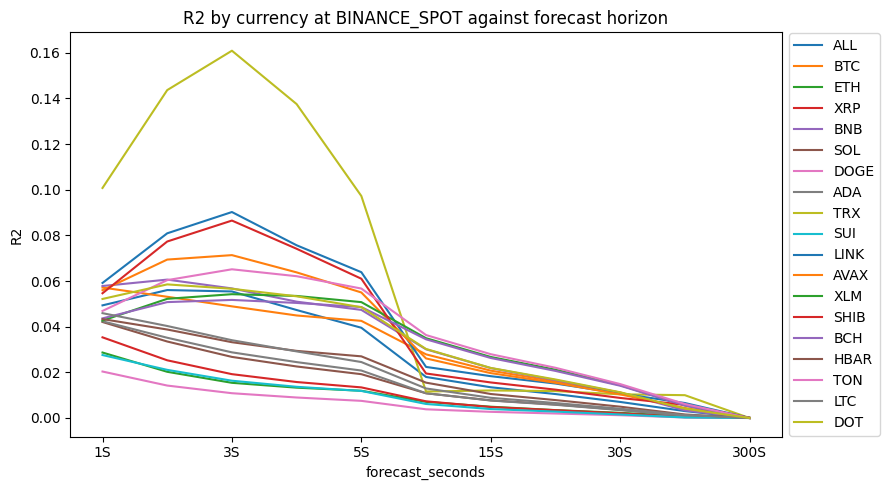

In [38]:
df_stats: pd.DataFrame = pd.concat(dfs)

ax = plt.figure(figsize=(9, 5)).add_subplot()

for currency in df_stats["currency"].unique():
    df_stats[df_stats["currency"] == currency].plot(x="forecast_seconds", y="R2", ax=ax, label=currency)


plt.ylabel("R2")
plt.title("R2 by currency at BINANCE_SPOT against forecast horizon")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig("r2_by_currency@binance_spot.png")

<h4>Study feature importances</h4>

In [44]:
dfs: List[pd.DataFrame] = []

for forecast_step in HORIZONS:
    path: Path = get_importance_file_path(
        target_exchange=target_exchange, forecast_step=forecast_step, day=ref_day
    )

    df_importances: pd.DataFrame = pd.read_csv(path)
    df_importances["forecast_seconds"] = forecast_step.total_seconds()
    dfs.append(df_importances)

df_importances: pd.DataFrame = pd.concat(dfs)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

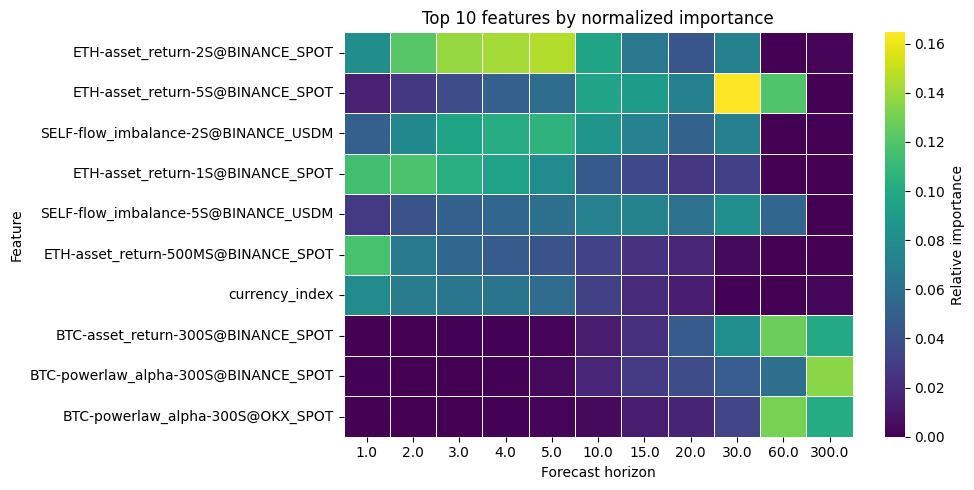

In [53]:
df_wide = (
    df_importances
    .pivot(index="feature", columns="forecast_seconds", values="importance")
    .fillna(0)
)

# 2) Normalize within each horizon (optional, so columns sum to 1)
df_norm = df_wide.div(df_wide.sum(axis=0), axis=1)

# 3) Sort features by *mean* importance across all horizons
feature_order = df_norm.mean(axis=1).sort_values(ascending=False).index
df_norm = df_norm.reindex(feature_order)

plt.figure(figsize=(10, 5))
sns.heatmap(
    df_norm.iloc[:10],
    cmap="viridis",
    cbar_kws={"label": "Relative importance"},
    linewidths=0.5,
)
plt.xlabel("Forecast horizon")
plt.ylabel("Feature")
plt.title(f"Top {topn} features by normalized importance")
plt.tight_layout()
plt.savefig("feature_importances_against_all_horizons@binance_spot.png")
plt.show()